###  COVIRT19 microbial subgroup seqscreen analysis troubleshooting v2.0 (Mike Lee Revisions)
#### Date : 16 DEC 2020 
#### Maintained by :
    Jochum, Michael D. 
    Baylor College of Medicine 
    michael.jochum@bcm.edu

#### The purpose of this code is to:
- to show ML the dmm issues 
- clean up the code a bit

In [1]:
library(tidyverse)
library(phyloseq)
library(microbiome)
# library(DESeq2)
library(Maaslin2)
# library(parallel)
library(DirichletMultinomial)
# library(pheatmap)
# library(ggpubr)
# library(viridis)
# library(mosaic)
library(tictoc)
setwd('/media/jochum00/Aagaard_Raid3/jupyter_notebooks/jochum00_jupyter/microbial/GO_term_analysis/16_DEC_2020_dmm_troubleshooting_Lee/')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2020 Leo Lahti, 
    Sudarshan Shetty et al. <microbiome.github.io>



Attaching package: ‘microbiome’


The following object is masked from ‘package:ggplot2’:

    alpha


The following object is masked from ‘package:base’:

    transform


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEv

In [2]:
#### WAY THAT DOESN'T WORK #####

In [3]:
raw<-as_tibble(read.table("../Combined_BALF_GO_Terms_parent_propagated.tsv", sep = "\t", row.names = NULL, header = T, quote = "", comment.char = ""))
colnames(raw)<-gsub("NA_tax","unclass", colnames(raw))%>%str_replace_all("NC1_SRR7796663", "NC1.SRR7796663")

In [4]:
df<-raw %>%
  select(GO_term,namespace,depth,name,ends_with("_counts"))%>%
  pivot_longer(cols = -c(GO_term,namespace,depth,name),
               names_to =  c("sample","type","abund"),
               names_pattern = "(.*)_(.*)_(.*)")%>%
  select(-abund)%>%
  filter(value>1)%>%
  pivot_wider(names_from = sample, values_from=value, values_fill=0)

In [5]:
df$depth<-as.character(df$depth)

In [6]:
term<-df%>%filter(type!="NA")%>%filter(type%in%c("bac","arc","vir"))%>%group_by(GO_term,namespace,depth,name)%>%
  summarise(across(.cols = where(is.numeric), sum))

`summarise()` regrouping output by 'GO_term', 'namespace', 'depth' (override with `.groups` argument)



In [7]:
term_tax<-term%>%select(GO_term,namespace,depth,name)
term_tax<-data.frame(term_tax, row.names=1)
term_counts<-data.frame(term[5:172], row.names = term$GO_term)

In [8]:
term_counts_phy <- otu_table(term_counts, taxa_are_rows=TRUE)
term_tax_phy <- tax_table(as.matrix(term_tax), errorIfNULL=TRUE)

In [9]:
term_sam<-as.data.frame(read.table("../Combined_BALF_GO_Terms_metadata2.txt",header = T, sep = "\t",row.names = 1))
rownames(term_sam)<-rownames(term_sam)%>%str_replace_all("NC1_SRR7796663", "NC1.SRR7796663")
term_sam$accession<-rownames(term_sam)

In [10]:
term_sam$outcome<-term_sam$outcome%>%
  str_replace_all("recovered", "Recovered")%>%
  str_replace_all("deceased","Deceased")%>%
  str_replace_all('stabilized',"Stabilized")
term_sam$sex<-term_sam$sex%>%
  str_replace_all("M", "male")%>%
  str_replace_all("F", "female")%>%
  str_replace_all("na", "<NA>") # this is mixing the string "<NA>" with actual NAs, probably not related to our problem, but def not a good idea in general

In [11]:
term_pseq <- phyloseq(term_counts_phy, term_tax_phy, sample_data(term_sam))
term_pseq# [ 14581 taxa and 167 samples ] [ 27077 taxa and 167 samples ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14581 taxa and 167 samples ]
sample_data() Sample Data:       [ 167 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 14581 taxa by 3 taxonomic ranks ]

In [12]:
filtme<-c("GO:0003674")
term_pseq <- prune_taxa(taxa=taxa_names(term_pseq)!=filtme, term_pseq)
filtme<-c("GO:0008150")
term_pseq <- prune_taxa(taxa=taxa_names(term_pseq)!=filtme, term_pseq)
term_pseq #[ 14579 taxa and 167 samples ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14579 taxa and 167 samples ]
sample_data() Sample Data:       [ 167 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 14579 taxa by 3 taxonomic ranks ]

In [13]:
term_pseq_no_neg<-subset_samples(term_pseq, sample_type!="neg_control")
term_pseq_no_neg# [ 14579 taxa and 162 samples ]:
term_pseq_no_neg<-subset_samples(term_pseq_no_neg, sample_type!="Unknown")
term_pseq_no_neg#  [ 14579 taxa and 141 samples ]:
term_pseq_no_neg<-subset_samples(term_pseq_no_neg, case!="Control_Sick")
term_pseq_no_neg# [ 14597 taxa and 105 samples ]
term_pseq_no_neg<-subset_samples(term_pseq_no_neg,publication!="Michalovich")
term_pseq_no_neg# [ 14597 taxa and 102 samples ]
term_pseq_no_neg<-subset_samples(term_pseq_no_neg, bioproject!="PRJNA605907")
term_pseq_no_neg# [ 14597 taxa and 86 samples ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14579 taxa and 162 samples ]
sample_data() Sample Data:       [ 162 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 14579 taxa by 3 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14579 taxa and 141 samples ]
sample_data() Sample Data:       [ 141 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 14579 taxa by 3 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14579 taxa and 105 samples ]
sample_data() Sample Data:       [ 105 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 14579 taxa by 3 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14579 taxa and 102 samples ]
sample_data() Sample Data:       [ 102 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 14579 taxa by 3 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14579 taxa and 86 samples ]
sample_data() Sample Data:       [ 86 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 14579 taxa by 3 taxonomic ranks ]

In [14]:
term_pseq_no_neg<-prune_taxa(taxa = taxa_sums(term_pseq_no_neg)>0,x = term_pseq_no_neg)
term_pseq_no_neg# [ 13534 taxa and 86 samples ]
term_pseq_no_neg<-prune_samples(samples = sample_sums(term_pseq_no_neg)>0,x = term_pseq_no_neg)
term_pseq_no_neg# [ 13534 taxa and 86 samples ] # [ 25426 taxa and 86 samples ]
term_pseq_no_neg_gonames<-term_pseq_no_neg

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 13534 taxa and 86 samples ]
sample_data() Sample Data:       [ 86 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 13534 taxa by 3 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 13534 taxa and 86 samples ]
sample_data() Sample Data:       [ 86 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 13534 taxa by 3 taxonomic ranks ]

In [15]:
tax<-data.frame(tax_table(term_pseq_no_neg))
names<-paste(rownames(tax),tax$name,sep="-")
taxa_names(term_pseq_no_neg)<-names

### ok lets play with the counts to see if we cant get this thing to run!

In [86]:
pseq <- term_pseq_prune
pseq #[ 35 taxa and 86 samples ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 41 taxa and 86 samples ]
sample_data() Sample Data:       [ 86 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 41 taxa by 3 taxonomic ranks ]

## ok time to just try the big one and see what happens

In [146]:
pseq<-term_pseq_no_neg

##########################################################

In [142]:
#Lets try sqrt root
dat <-(sqrt(abundances(pseq)))
min(rowSums(dat))
max(rowSums(dat))
min(colSums(dat))
max(colSums(dat))
count <- as.matrix(t(dat))
print(range(count))

[1] 1.414214

[1] 131238.2

[1] 6396.684

[1] 1775110

[1]     0.00 18300.45


[1] "dmm modeling starting"


dmn, k=1



  Soft kmeans
  Expectation Maximization setup
  Expectation Maximization
  Hessian


dmn, k=2



  Soft kmeans
    iteration 10 change 0.000002
  Expectation Maximization setup
  Expectation Maximization
    iteration 10 change 0.000000
  Hessian


dmn, k=3



  Soft kmeans
    iteration 10 change 0.000008
  Expectation Maximization setup
  Expectation Maximization
  Hessian


dmn, k=4



  Soft kmeans
    iteration 10 change 0.000019
  Expectation Maximization setup
  Expectation Maximization
  Hessian


dmn, k=5



  Soft kmeans
    iteration 10 change 0.000014
  Expectation Maximization setup
  Expectation Maximization
  Hessian


dmn, k=6



  Soft kmeans
    iteration 10 change 0.000011
  Expectation Maximization setup
  Expectation Maximization
  Hessian


dmn, k=7



  Soft kmeans
    iteration 10 change 0.000016
  Expectation Maximization setup
  Expectation Maximization
  Hessian


dmn, k=8



  Soft kmeans
    iteration 10 change 0.000040
  Expectation Maximization setup
  Expectation Maximization
  Hessian
[1] "dmm modeling finished"
[[1]]
class: DMN 
k: 1 
samples x taxa: 86 x 13534 
Laplace: 1357724 BIC: 1384701 AIC: 1368092 

[[2]]
class: DMN 
k: 2 
samples x taxa: 86 x 13534 
Laplace: 1306902 BIC: 1369216 AIC: 1335998 

[[3]]
class: DMN 
k: 3 
samples x taxa: 86 x 13534 
Laplace: 1293275 BIC: 1389530 AIC: 1339702 

[[4]]
class: DMN 
k: 4 
samples x taxa: 86 x 13534 
Laplace: 1313440 BIC: 1451359 AIC: 1384921 

[[5]]
class: DMN 
k: 5 
samples x taxa: 86 x 13534 
Laplace: 1334877 BIC: 1498268 AIC: 1415221 

[[6]]
class: DMN 
k: 6 
samples x taxa: 86 x 13534 
Laplace: Inf BIC: 1570745 AIC: 1471087 

[[7]]
class: DMN 
k: 7 
samples x taxa: 86 x 13534 
Laplace: Inf BIC: 1632367 AIC: 1516100 

[[8]]
class: DMN 
k: 8 
samples x taxa: 86 x 13534 
Laplace: Inf BIC: 1706157 AIC: 1573280 

dmm_modeling: 13993.35 sec elapsed


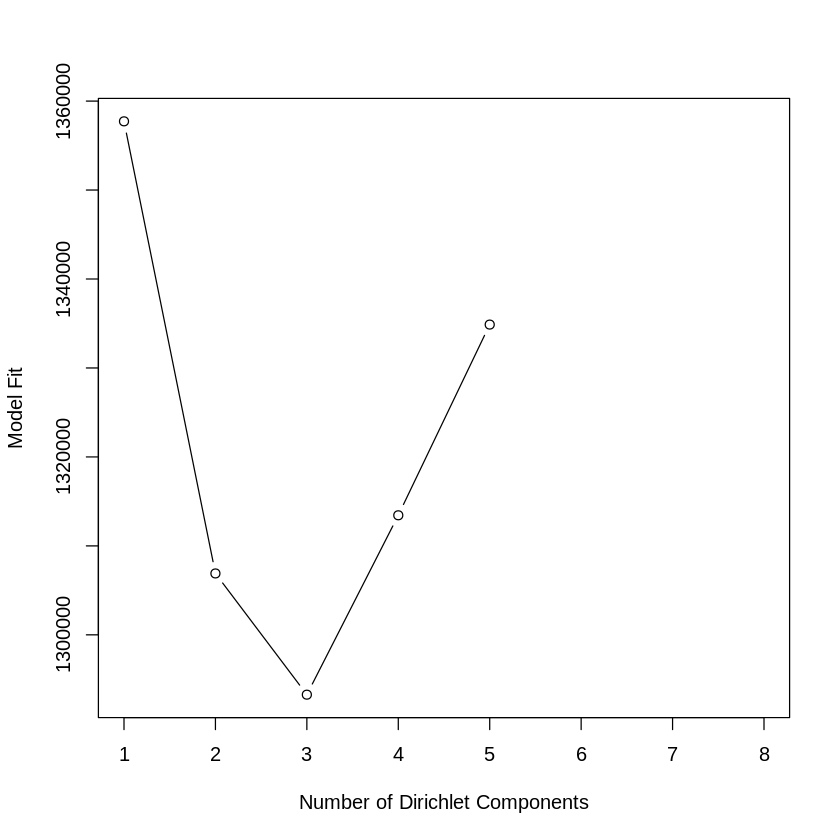

In [145]:
tic("dmm_modeling")
    print("dmm modeling starting")
    fit <- lapply(1:8, dmn, count = count, verbose=TRUE)
    print("dmm modeling finished")
    print(fit)
toc()
set.seed(seed = 3.14159265358979) #cool number
lplc <- sapply(fit, laplace) # AIC / BIC / Laplace
aic  <- sapply(fit, AIC) # AIC / BIC / Laplace
bic  <- sapply(fit, BIC) # AIC / BIC / Laplace
plot(lplc, type="b", xlab="Number of Dirichlet Components", ylab="Model Fit")

# SQUARE ROOT DID IT!!!! 
# yahoooooooooo!!!!


In [147]:
best <- fit[[which.min(lplc)]]
#best <-fit[[4]]
best

class: DMN 
k: 3 
samples x taxa: 86 x 13534 
Laplace: 1293275 BIC: 1389530 AIC: 1339702 

In [148]:
#save.image(file = "go_terms_dmm.rdata")

#make a heatmap visualization of the cluster

log 2 Heatmap

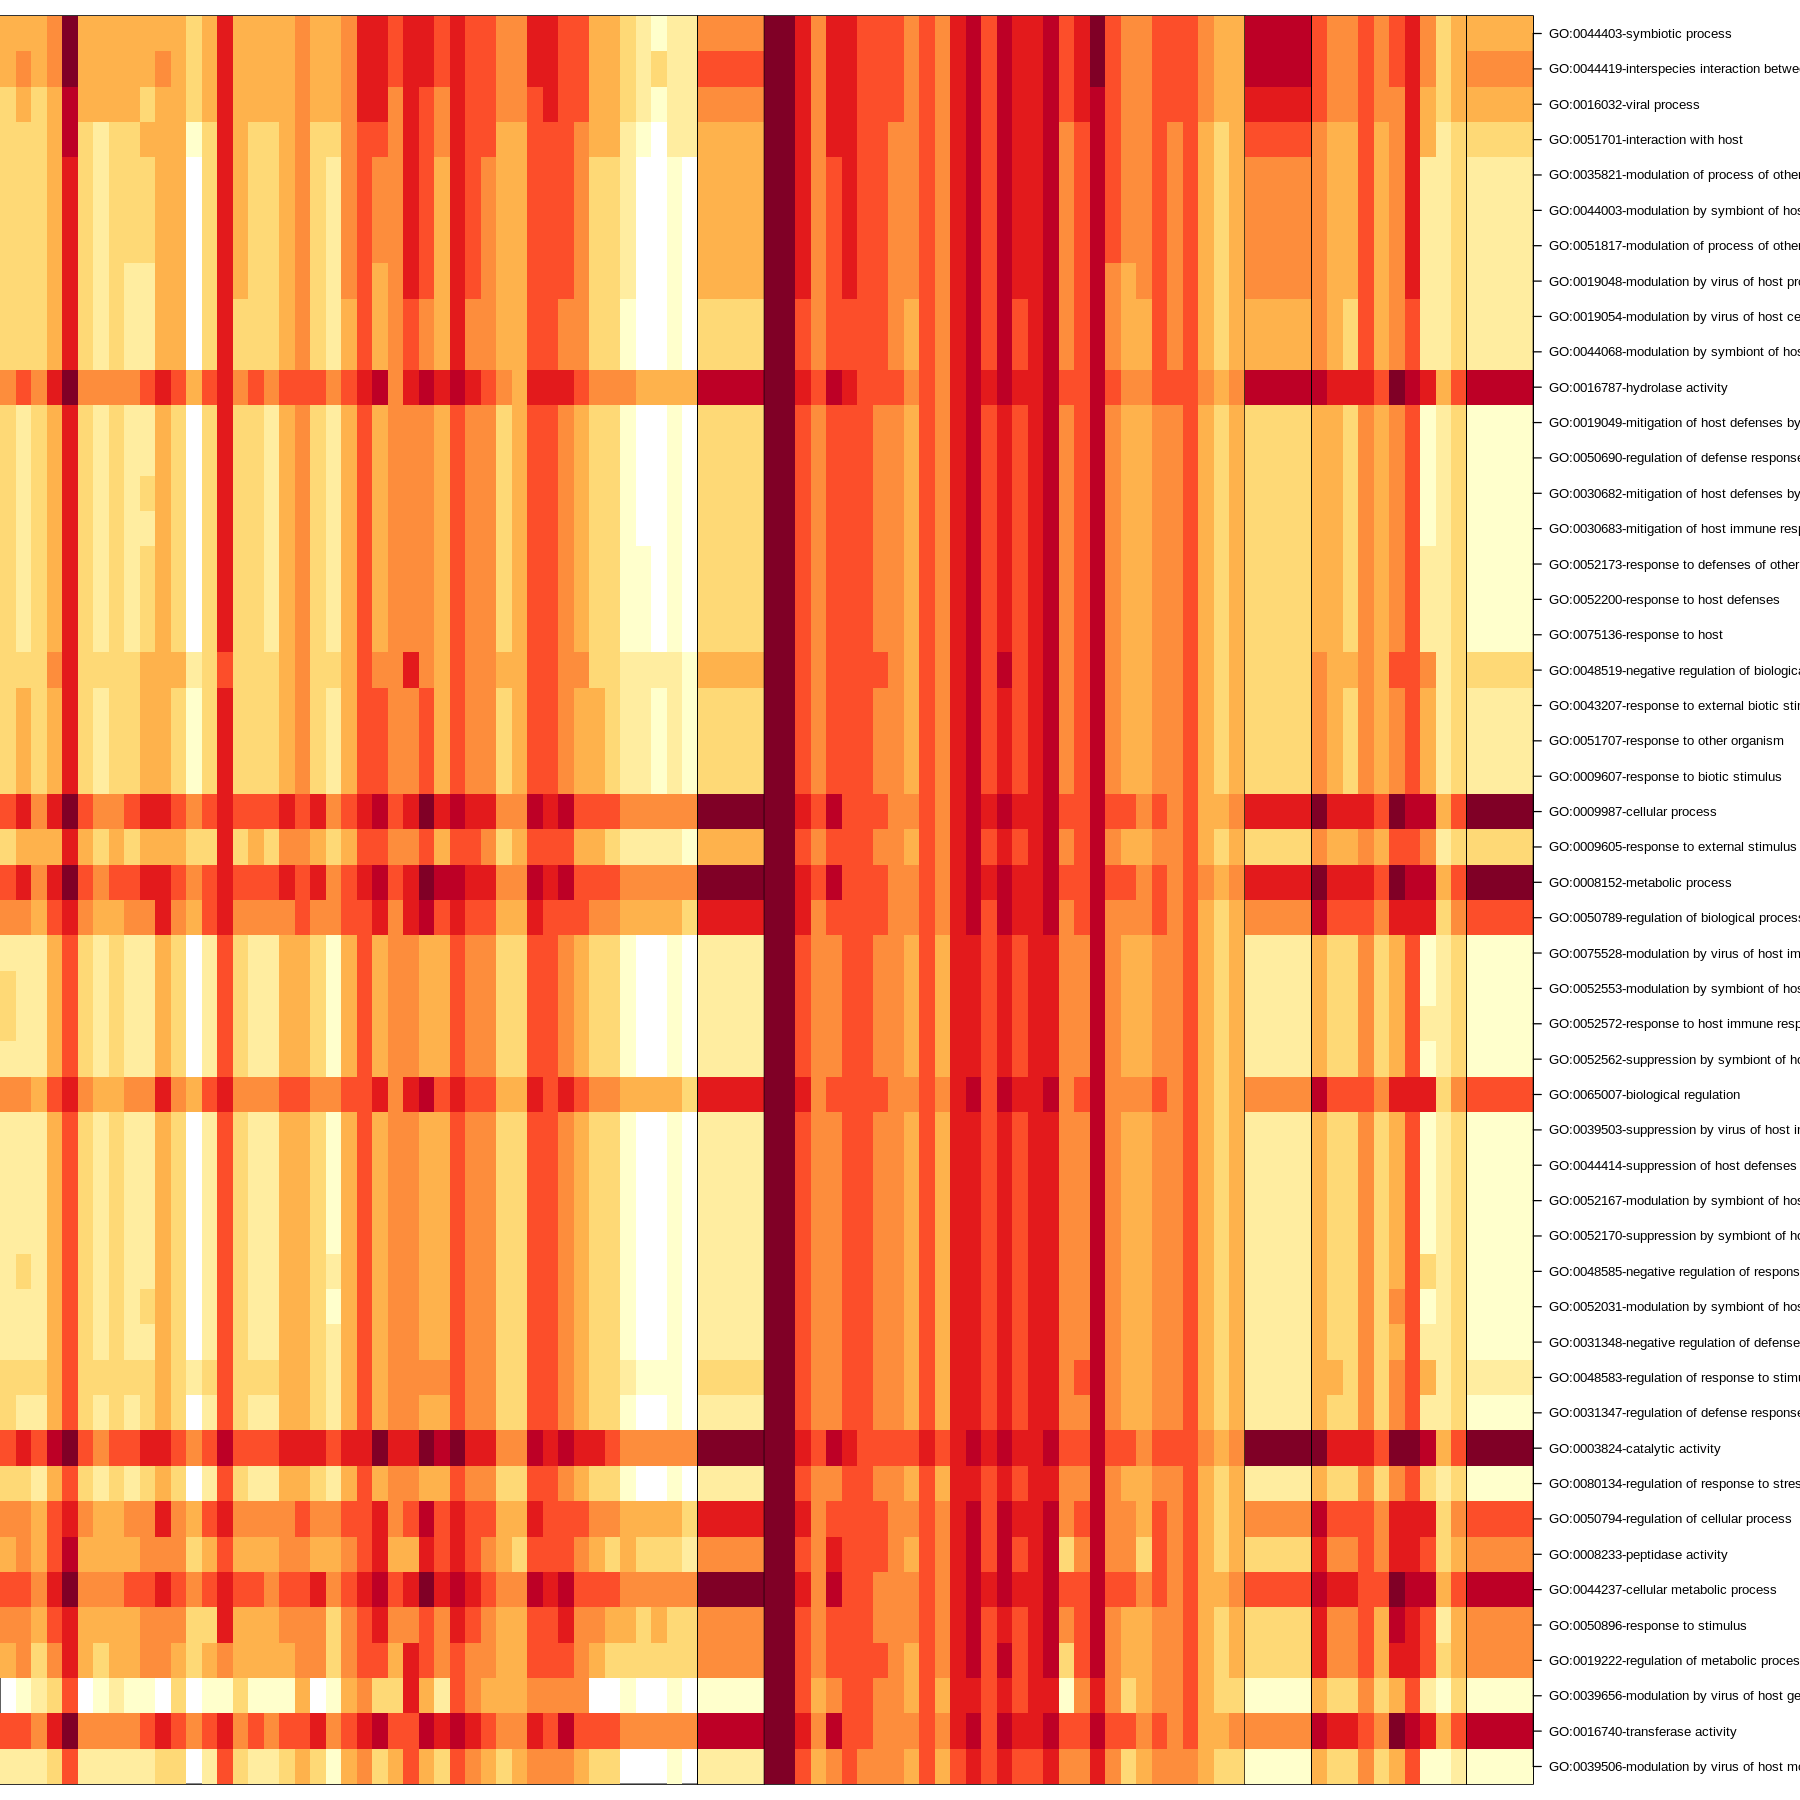

In [149]:
options(repr.plot.width=15, repr.plot.height=15)
heatmapdmn(count, fit[[1]], best,ntaxa = 50,
           transform =log2, lblwidth = 0.2 * nrow(count))

square root version

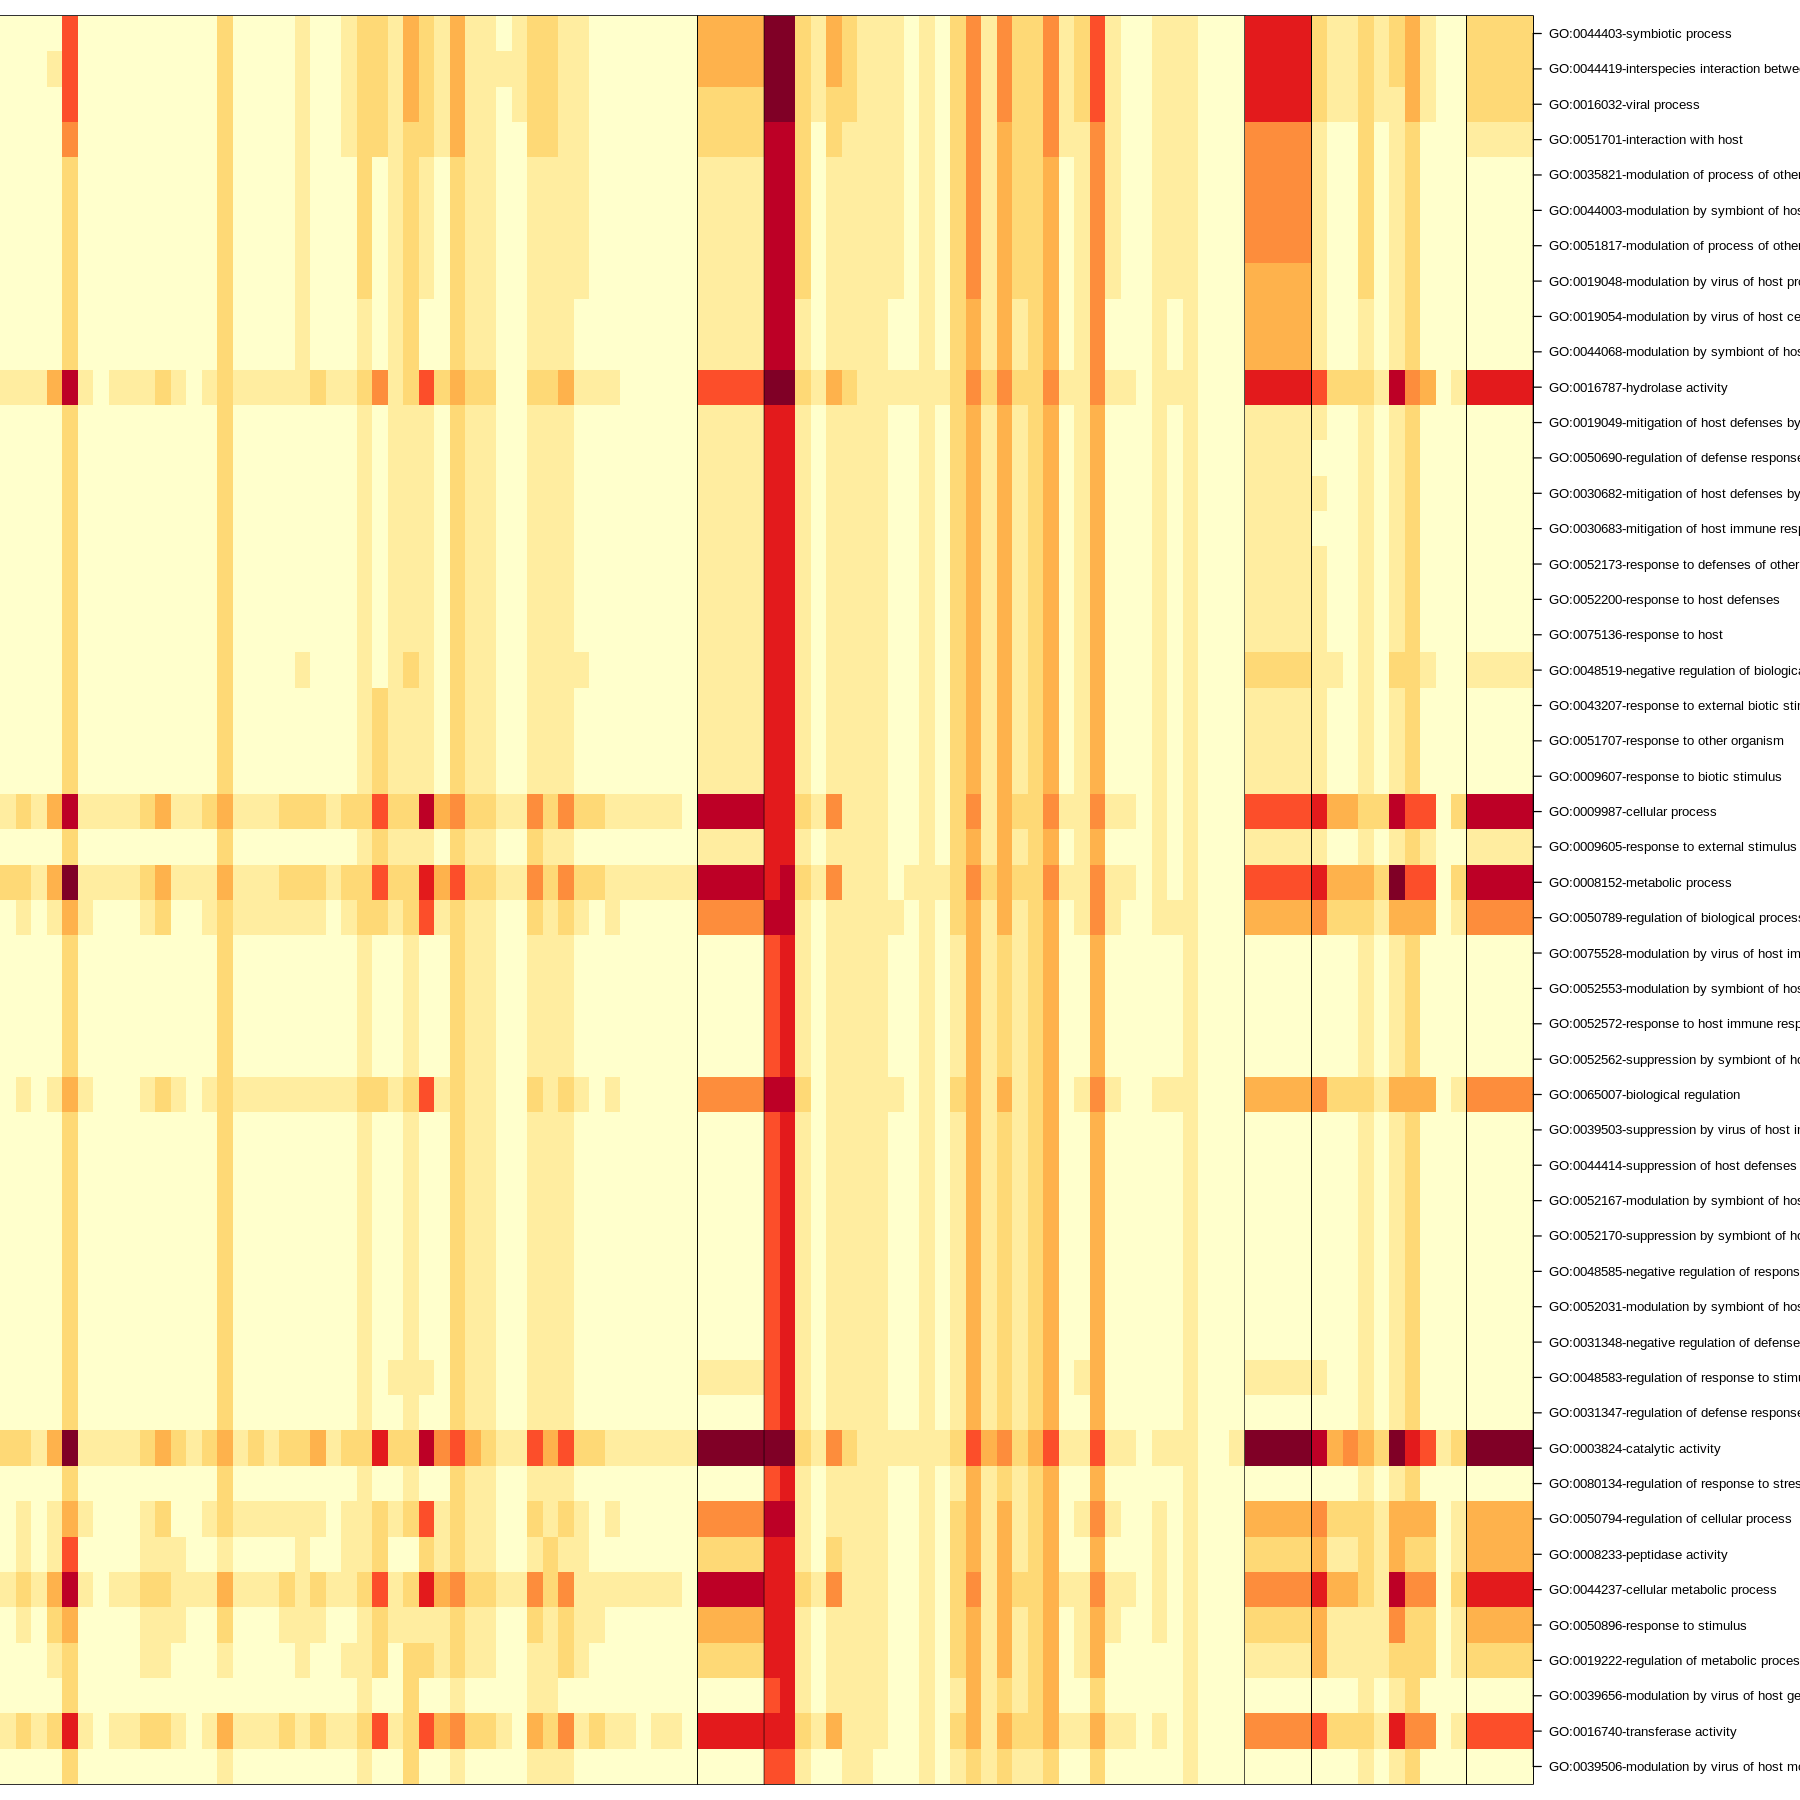

In [150]:
options(repr.plot.width=15, repr.plot.height=15)
heatmapdmn(count, fit[[1]], best,ntaxa = 50,
           transform =sqrt, lblwidth = 0.2 * nrow(count))

print out the theta values

In [151]:
mixturewt(best)

pi,theta
<dbl>,<dbl>
0.5232558,8671.682
0.3604651,5118.388
0.1162791,40719.202


save the datasheet that show which GO terms contributed to each dmm group

In [152]:
write.table(fitted(best),"GO_TERMS_DMM_contributions.tsv", sep="\t")

save a datasheet that identifies which sample belongs to which dmm group

In [153]:
ass <- apply(mixture(best), 1, which.max)
write.table(ass,"GO_TERMS_DMM_groups.tsv",sep="")

In [169]:
#add the dmm group to the metadata
sample_data(term_pseq_prune)$dmn<-ass
term_pseq_prune_comp<-microbiome::transform(term_pseq_prune,"compositional")
#melt the phyloseq object into tidy form
tmp<-psmelt(term_pseq_prune_comp)
tmp<-as_tibble(tmp)

In [170]:
library(ggpubr)

Warning message:
“Using `bins = 30` by default. Pick better value with the argument `bins`.”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 25 rows containing non-finite values (stat_bin).”


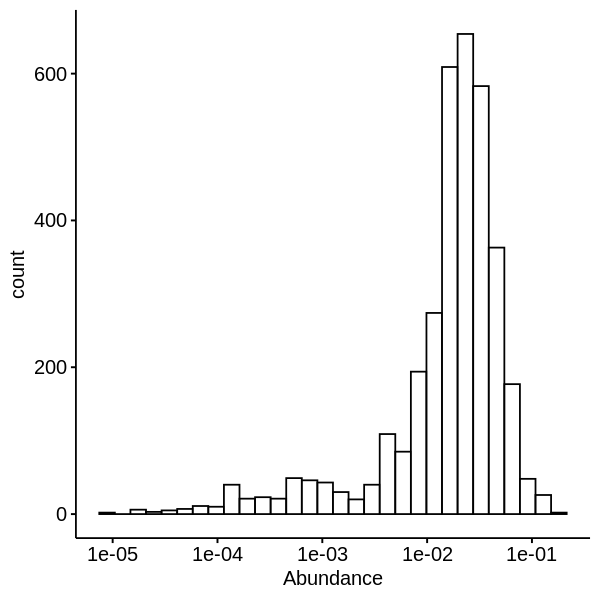

In [171]:
options(repr.plot.width=5, repr.plot.height=5)
gghistogram(tmp,x = "Abundance",y = "..count..")+scale_x_log10() #move each dmm group into a colum of its own

In [172]:
#tmp$log2Abundance<-log2(tmp$Abundance)

In [173]:
#subset the dataset to only include the case, Go_term, count, and dmm group.
#obtain the avergage count for each Go term
#order the go terms from hight to lowest count

I added these filtering commands to pull out the counts with less than 1% relabund or greater tahn 22% (ie:molecular function)

In [174]:
d2<-tmp %>%
  select(case,OTU,Abundance, dmn)%>%
  group_by(OTU,case, dmn) %>%
  summarise(avg = mean(Abundance)) %>%
  arrange(desc(avg))

`summarise()` regrouping output by 'OTU', 'case' (override with `.groups` argument)



In [177]:
#d2$avg<-sqrt(d2$avg)

In [178]:
#get the total count of the go terms and oder from greates to lowest
library(tidyverse)

In [183]:
d3<-tidyr::spread(d2,dmn,avg)
d3$tot<-rowSums(d3[3:5], na.rm = T)
 d3<-d3%>%arrange(desc(tot))
 d3$tot<-NULL
 head(d3)

OTU,case,1,2,3
<chr>,<chr>,<dbl>,<dbl>,<dbl>
GO:0003824-catalytic activity,COVID19,0.09410686,0.07827463,0.11054949
GO:0003824-catalytic activity,Community_acquired_pneumonia,0.09636990,0.07529634,0.10508770
GO:0009987-cellular process,Community_acquired_pneumonia,0.06116176,0.04552415,0.08100746
GO:0003824-catalytic activity,Control_Healthy,0.10690598,0.07719463,NA
GO:0008152-metabolic process,Community_acquired_pneumonia,0.06069600,0.03972971,0.07353071
GO:0008152-metabolic process,COVID19,0.06432980,0.03321543,0.06585538


In [184]:
d3<-d3%>%gather(data = d3,avg,3:5)
colnames(d3)<-c("name","case", "dmn","avg")
d3

name,case,dmn,avg
<chr>,<chr>,<chr>,<dbl>
GO:0003824-catalytic activity,COVID19,1,0.09410686
GO:0003824-catalytic activity,Community_acquired_pneumonia,1,0.09636990
GO:0009987-cellular process,Community_acquired_pneumonia,1,0.06116176
GO:0003824-catalytic activity,Control_Healthy,1,0.10690598
GO:0008152-metabolic process,Community_acquired_pneumonia,1,0.06069600
GO:0008152-metabolic process,COVID19,1,0.06432980
GO:0009987-cellular process,COVID19,1,0.05608056
GO:0008152-metabolic process,Control_Healthy,1,0.07215001
GO:0071704-organic substance metabolic process,COVID19,1,0.05255467


make the balloon plot

In [185]:
d4<-d3%>%filter(avg>0.01)%>%arrange(name,case,dmn)
#d4<-d4[1:108,]
dim(d4)
dim(d3)

[1] 259   4

[1] 369   4

In [187]:
library(viridis)

Loading required package: viridisLite



In [188]:
my_pal<-viridis(n = 256, alpha = 1, begin = 0, end = 1, direction = 1)

Warning message:
“Removed 41 rows containing missing values (geom_point).”


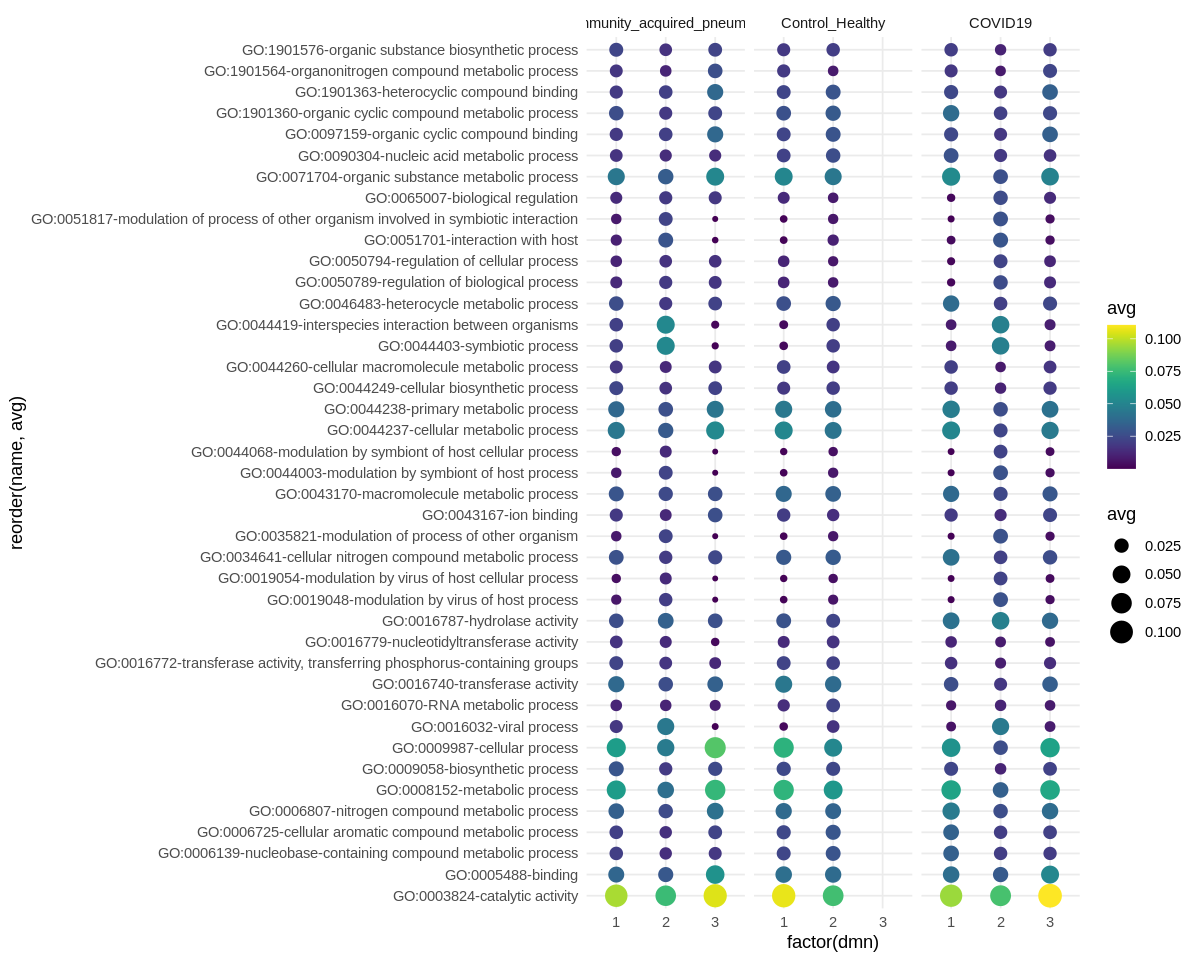

In [189]:
options(repr.plot.width=10, repr.plot.height=8)
a<-ggplot(data = d3,mapping = aes(x = factor(dmn),y =reorder(name,avg),size=avg,color=avg))+
geom_point()+
#theme(text=element_text(size=20))+
scale_colour_gradientn(colours = my_pal)+
facet_grid(facets = ~ case)+
theme_minimal()

a

Warning message:
“Removed 41 rows containing missing values (geom_point).”


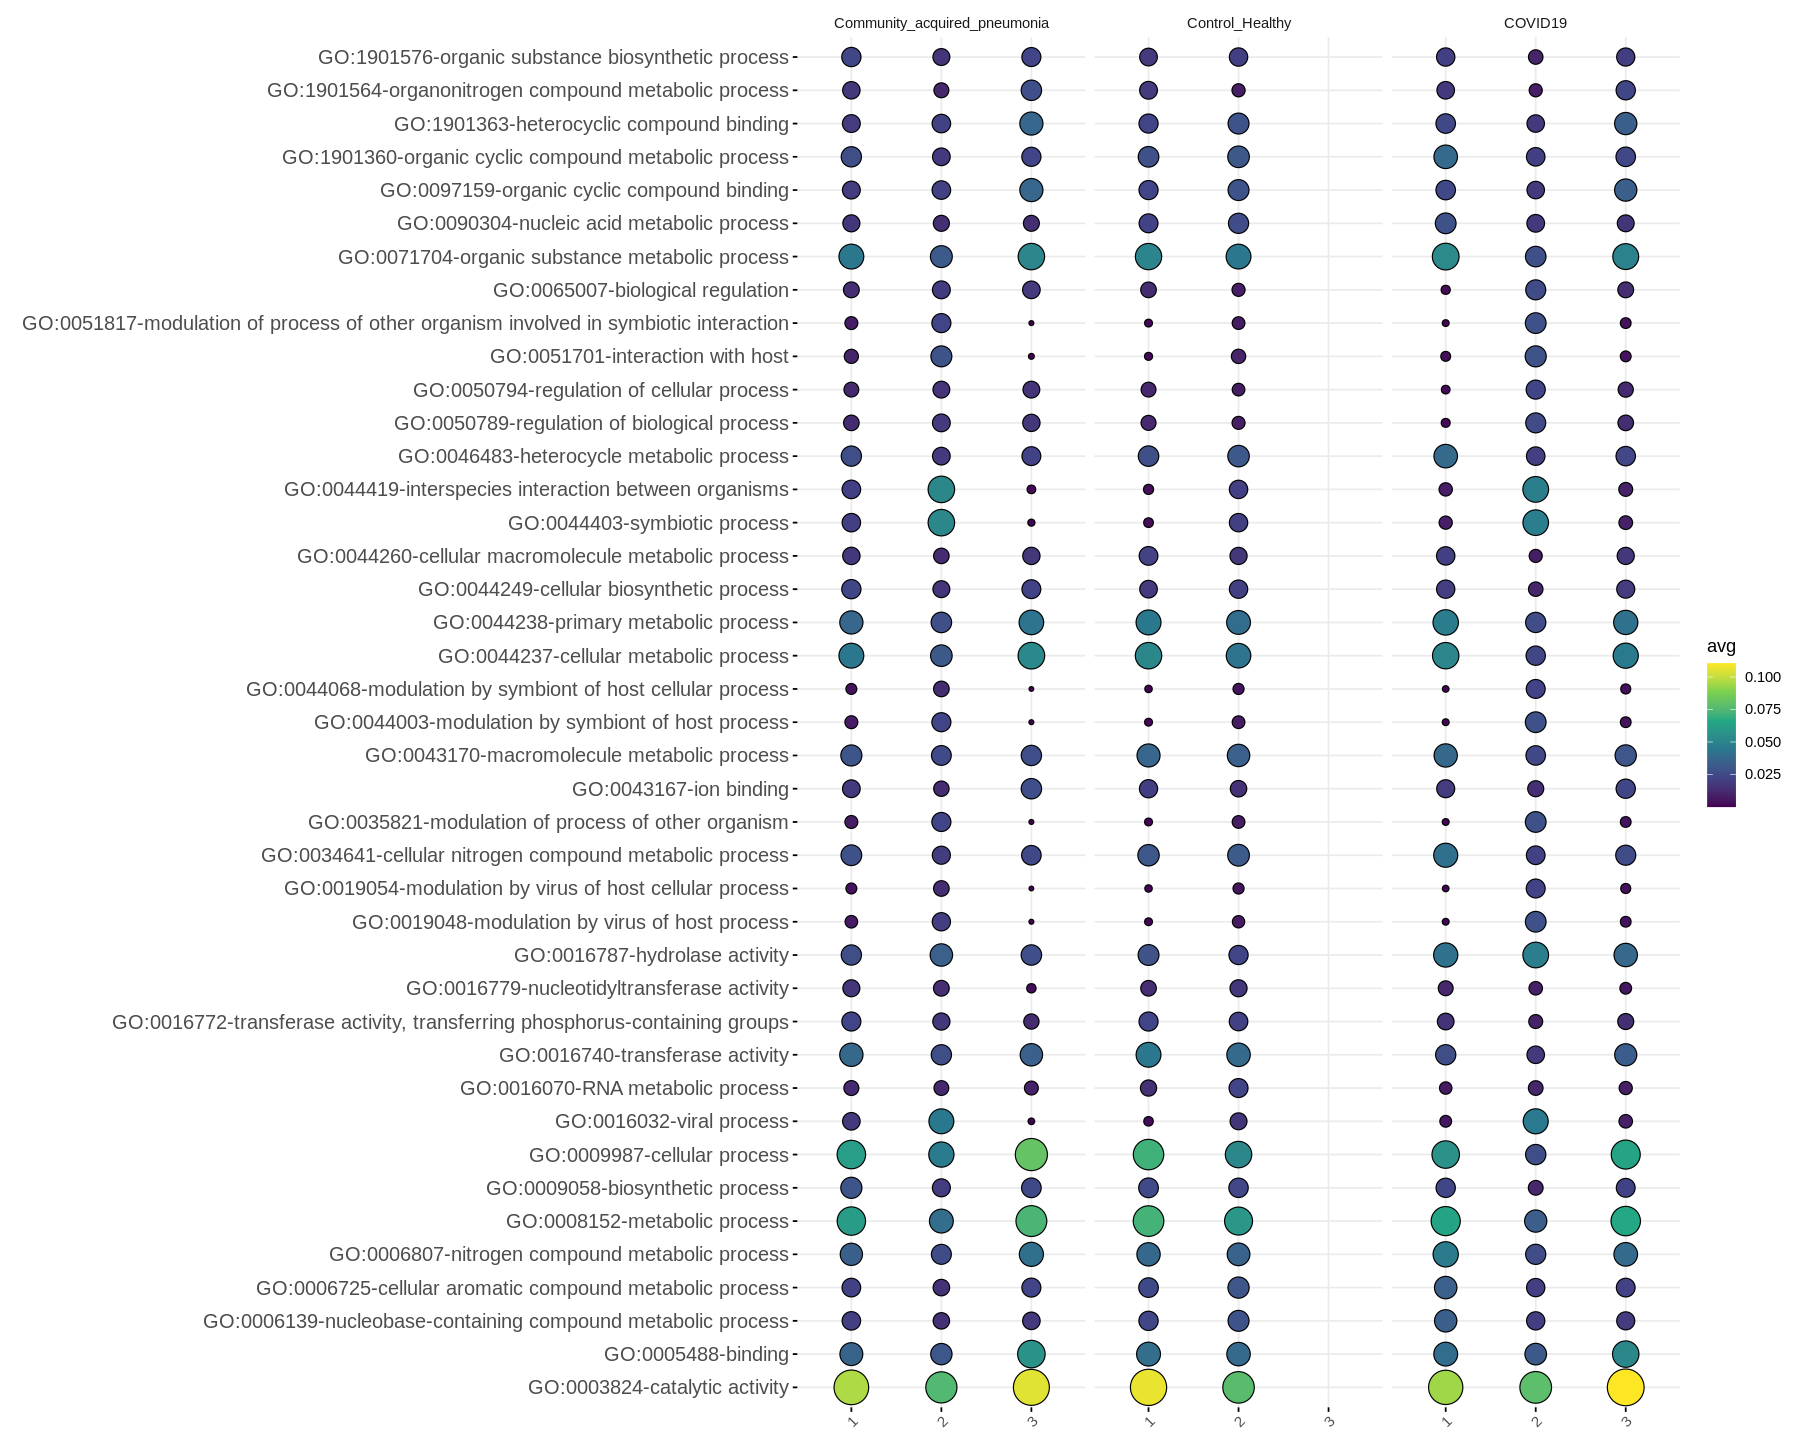

In [263]:
options(repr.plot.width=15, repr.plot.height=12)  
ggballoonplot(d3, y ="name",x = "dmn", size = "avg", facet.by = "case",fill = "avg",ggtheme = theme_minimal())+
     guides(size = FALSE)+
    font("y.text", size = 12)+scale_fill_viridis_c()

In [264]:
save.image("GO_TERM_Maaslin2_19_DEC_2020.rda")
#load.Rdata("GO_TERM_Maaslin2_19_NOV_2020.rda")

## DATA VISUALIZATION TIME and outcome comparison time

In [197]:
sam<-as_tibble(sample_data(term_pseq_prune))
library(mosaic)

Warning message in class(x) <- c(setdiff(subclass, tibble_class), tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”


In [198]:
tbl<-tally(x = case~dmn,sam, format = "count")

In [199]:
case<-as.vector(tally(~case,sam))
case
dmn<-as.vector(tally(~dmn,sam))
dmn
cor.test(case,dmn)
cor(case,dmn)
cov(case,dmn)

[1] 25 29 32

[1] 45 31 10


	Pearson's product-moment correlation

data:  x and y
t = -5.0037, df = 1, p-value = 0.1256
alternative hypothesis: true correlation is not equal to 0
sample estimates:
       cor 
-0.9806086 


[1] -0.9806086

[1] -60.66667

ok lets do a binomial test to see if we can use this

In [201]:
out_tbl<-tally(x = case=="COVID19"~dmn,sam)
result2 <-chisq.test(table(out_tbl))
out_tbl
result2
chisq(result2)

Warning message in chisq.test(table(out_tbl)):
“Chi-squared approximation may be incorrect”


                 dmn
case == "COVID19"  1  2  3
            TRUE   2 21  9
            FALSE 43 10  1


	Chi-squared test for given probabilities

data:  table(out_tbl)
X-squared = 0, df = 5, p-value = 1


X.squared 
        0

YAAAASSSSSS CASE ~OUTCOME Chi-squared TEST P=0.0517
LESGOOOO

## HEATMAP TIME

In [210]:
###########################################
###Dont forget to save you shit HERE#######
###########################################
#save.image(file = "bac_go_terms_dmm.rdata")
#
library(MatrixGenerics)

In [211]:
count<-abundances(term_pseq_prune)
select <- order(rowMeans(count),decreasing=TRUE)
select3<-order(rowSdDiffs(count),decreasing=T)
select2<-log1p((count)[select3,])
tmp<-rownames(select2)
dim(select2)


[1] 41 86

In [212]:
#select2$mol<-tmp
select_tibb<-as_tibble(select2)
rownames(select_tibb)<-rownames(select2)
write.table(select2,file = "GO_Terms_results")

Warning message:
“Setting row names on a tibble is deprecated.”


In [213]:
#library(matrixTests)
#library(genefilter)
#select3<-as_tibble(select2)%>%summarise(std=rowFtests(select2))%>% arrange(desc(std))
#select2$mol<-tmp
select2<-as_tibble(select2)
#select2$mean<-rowMeans(select2)

In [252]:
rownames(select2)<-tmp
sam<-data.frame(sample_data(term_pseq_prune))
df<-as.data.frame(sample_data(term_pseq_prune))
df<-as_tibble(df)
#df<-df%>%select(dmn, publication, sample_type,case,outcome)#dmn,body_site)
#update, removing sample type column after removing sick and micalovich samples
df<-df%>%select(dmn, publication, case,outcome)#dmn,body_site)
df<-as.data.frame(df)

Warning message:
“Setting row names on a tibble is deprecated.”
Warning message in class(x) <- c(setdiff(subclass, tibble_class), tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”


In [253]:
#select2<-sqrt((count)[select,])
dim(select2)
colnames(select2) <- colnames(otu_table(term_pseq_prune))
length(rownames(select2))
length(row.names(df))
row.names(df) <- colnames(select2)

[1] 41 86

[1] 41

[1] 86

In [254]:
library(ggsci)

In [255]:
mypal <- pal_aaas("default", alpha = 1)(10)
mypal
library("scales")
library(RColorBrewer)
library(viridis)
library(pheatmap)
df_row<-as.data.frame(fitted(best))
#colnames(df_row)<-c("1","2","3","4","5","6")
df<-data.frame(df)
#update, removing sampleType column after removinch "sick" samples
#colnames(df)<-c("dmm_cluster", "Publication","Sample_Type","Case","Outcome")
colnames(df)<-c("dmm_cluster", "Publication","Case","Outcome")

[1] "#3B4992FF" "#EE0000FF" "#008B45FF" "#631879FF" "#008280FF" "#BB0021FF"
 [7] "#5F559BFF" "#A20056FF" "#808180FF" "#1B1919FF"

In [256]:
ann_colors = list(
  dmm_cluster=c("1"="#3B4992FF","2"="#EE0000FF","3"="#008B45FF","4"="#631879FF","5"="#008280FF","6"="#BB0021FF","7"="#5F559BFF"),
  Publication=c("Xiong"="#008280FF", "Shen"="#631879FF","Michalovich"="#BB0021FF","Chen"="#3B4992FF","Wu"="#EE0000FF","Zhou"="orange","Ren"="#111111"),
  Sample_Type =c("COVID_19"="firebrick",
                 "Healthy"="forestgreen",
                 "Community_acquired_pneumonia"="darkorange1",
                 "Obese_Asthma"="goldenrod3",
                 "Obese_Smoker"="goldenrod4", 
                 "Obese"="goldenrod1",
                 "Asthma"= "dodgerblue2", 
                 "Asthma_Smoker"="dodgerblue4",
                 "Asthma_Ex_smoker"="dodgerblue3",
                 "Smoker"="gray27",
                 "Obese_Asthma_Smoker"="black"),
  Case=c("COVID19"="firebrick","Community_acquired_pneumonia"="darkorange1", "Control_Healthy"="forestgreen","Control_Sick"="dodgerblue4"),
Outcome=c("Deceased"="black","Stabilized"="goldenrod4","Recovered"="forestgreen"))

In [257]:
ann_colors = list(
  dmm_cluster=c("1"="#EE0000FF","2"="#3B4992FF","3"="#008B45FF"),#,"4"="#631879FF"),#,"5"="#008280FF","6"="#BB0021FF","7"="#5F559BFF"),
  Publication=c("Xiong"="#008280FF", "Shen"="#631879FF","Chen"="#3B4992FF","Wu"="#EE0000FF","Zhou"="orange","Ren"="#111111"),
  Case=c("COVID19"="firebrick","Community_acquired_pneumonia"="darkorange1", "Control_Healthy"="forestgreen"),
 # Sample_Type=c("COVID_19"="firebrick","Community_acquired_pneumonia"="darkorange1", "Healthy"="forestgreen"),
Outcome=c("Deceased"="black","Stabilized"="goldenrod4","Recovered"="forestgreen"))

In [258]:
select3<-select2%>%filter(rowMeans(select2)>8)
dim(select2)
dim(select3)

[1] 41 86

[1] 41 86

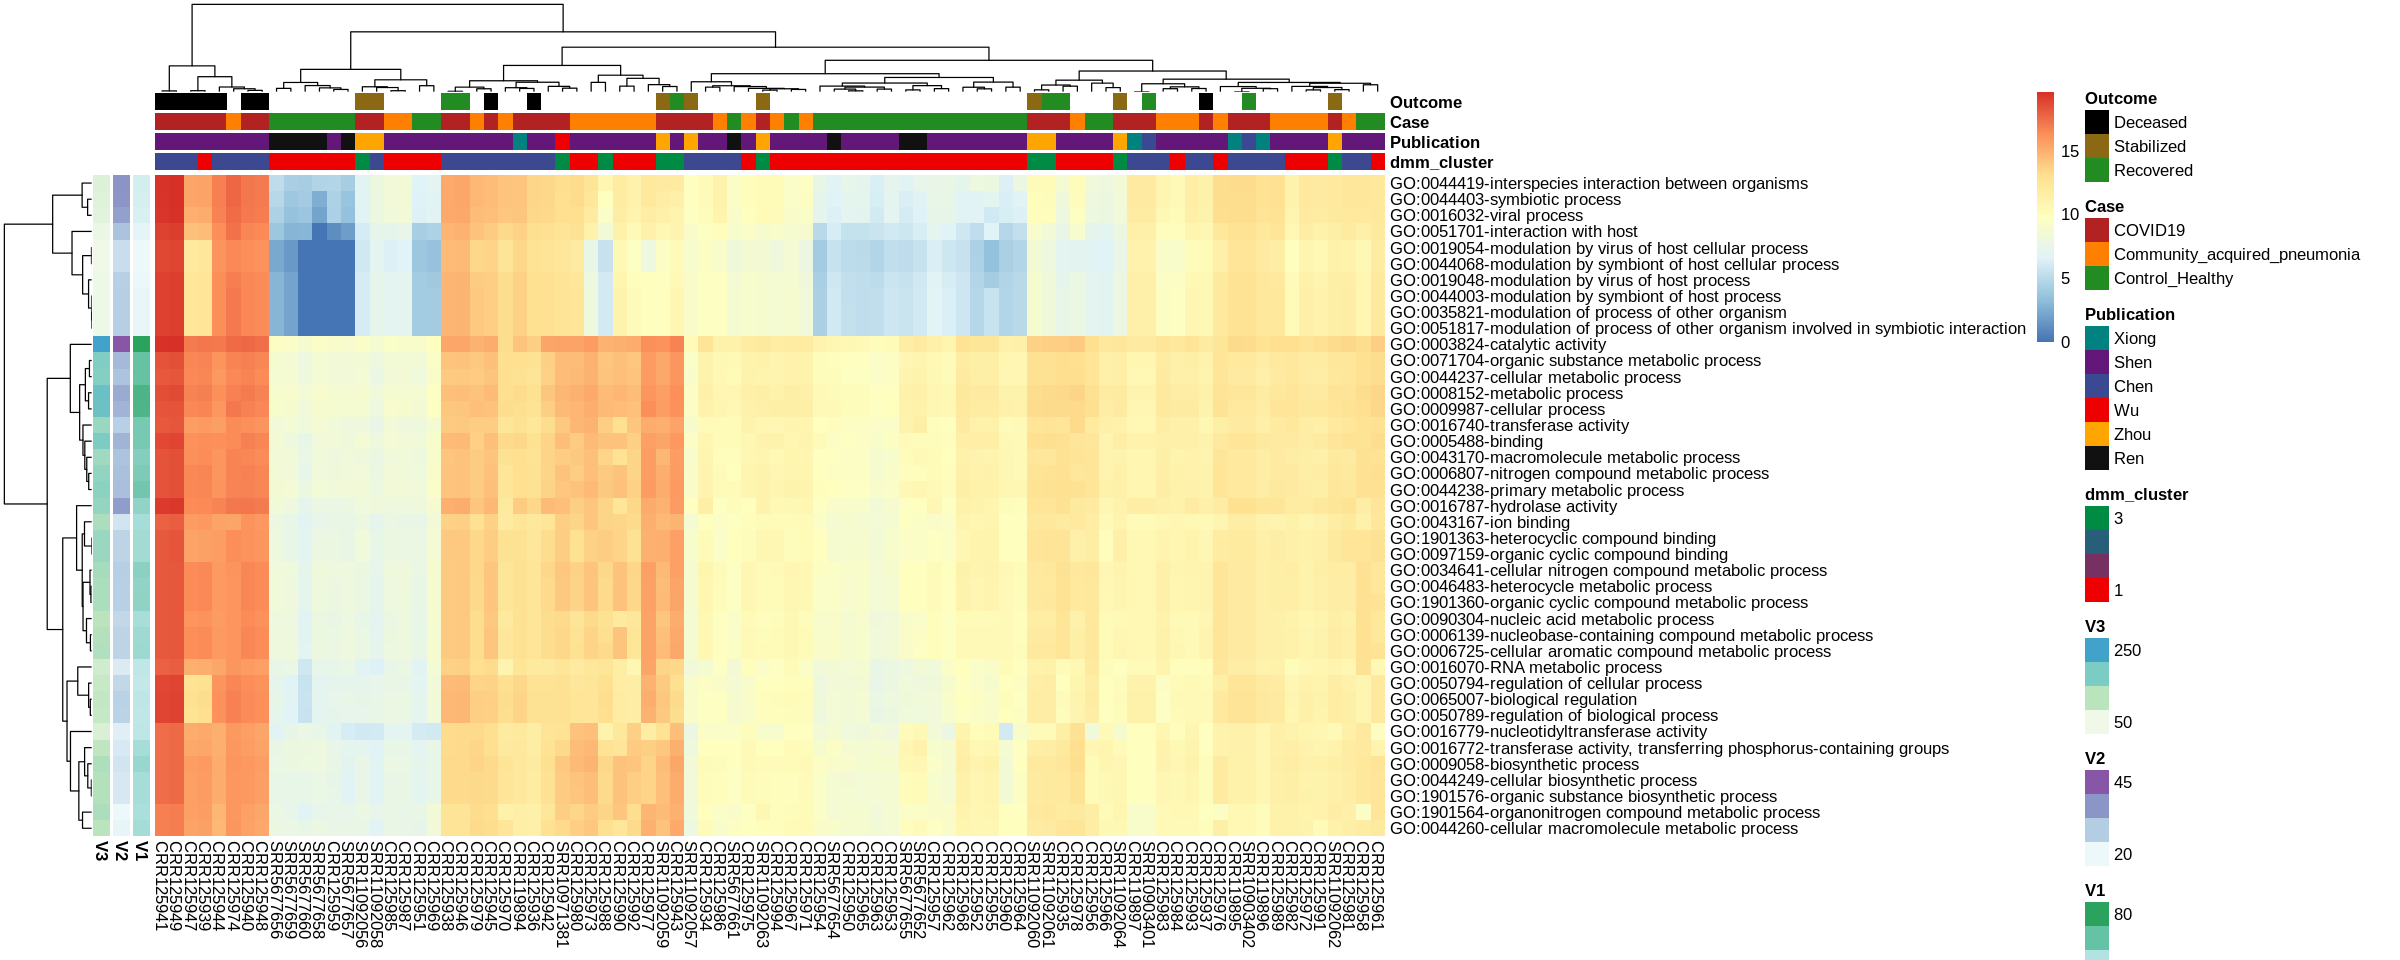

In [259]:
options(repr.plot.width=20, repr.plot.height=8)
xx <- pheatmap(mat = select3,
               color = colorRampPalette(rev(brewer.pal(n = 7, name ="RdYlBu")))(1000),
               annotation_col=df,
               annotation_colors = ann_colors,
               clustering_distance_rows = "euclidean",
               clustering_distance_cols = "euclidean",
              annotation_row = df_row)

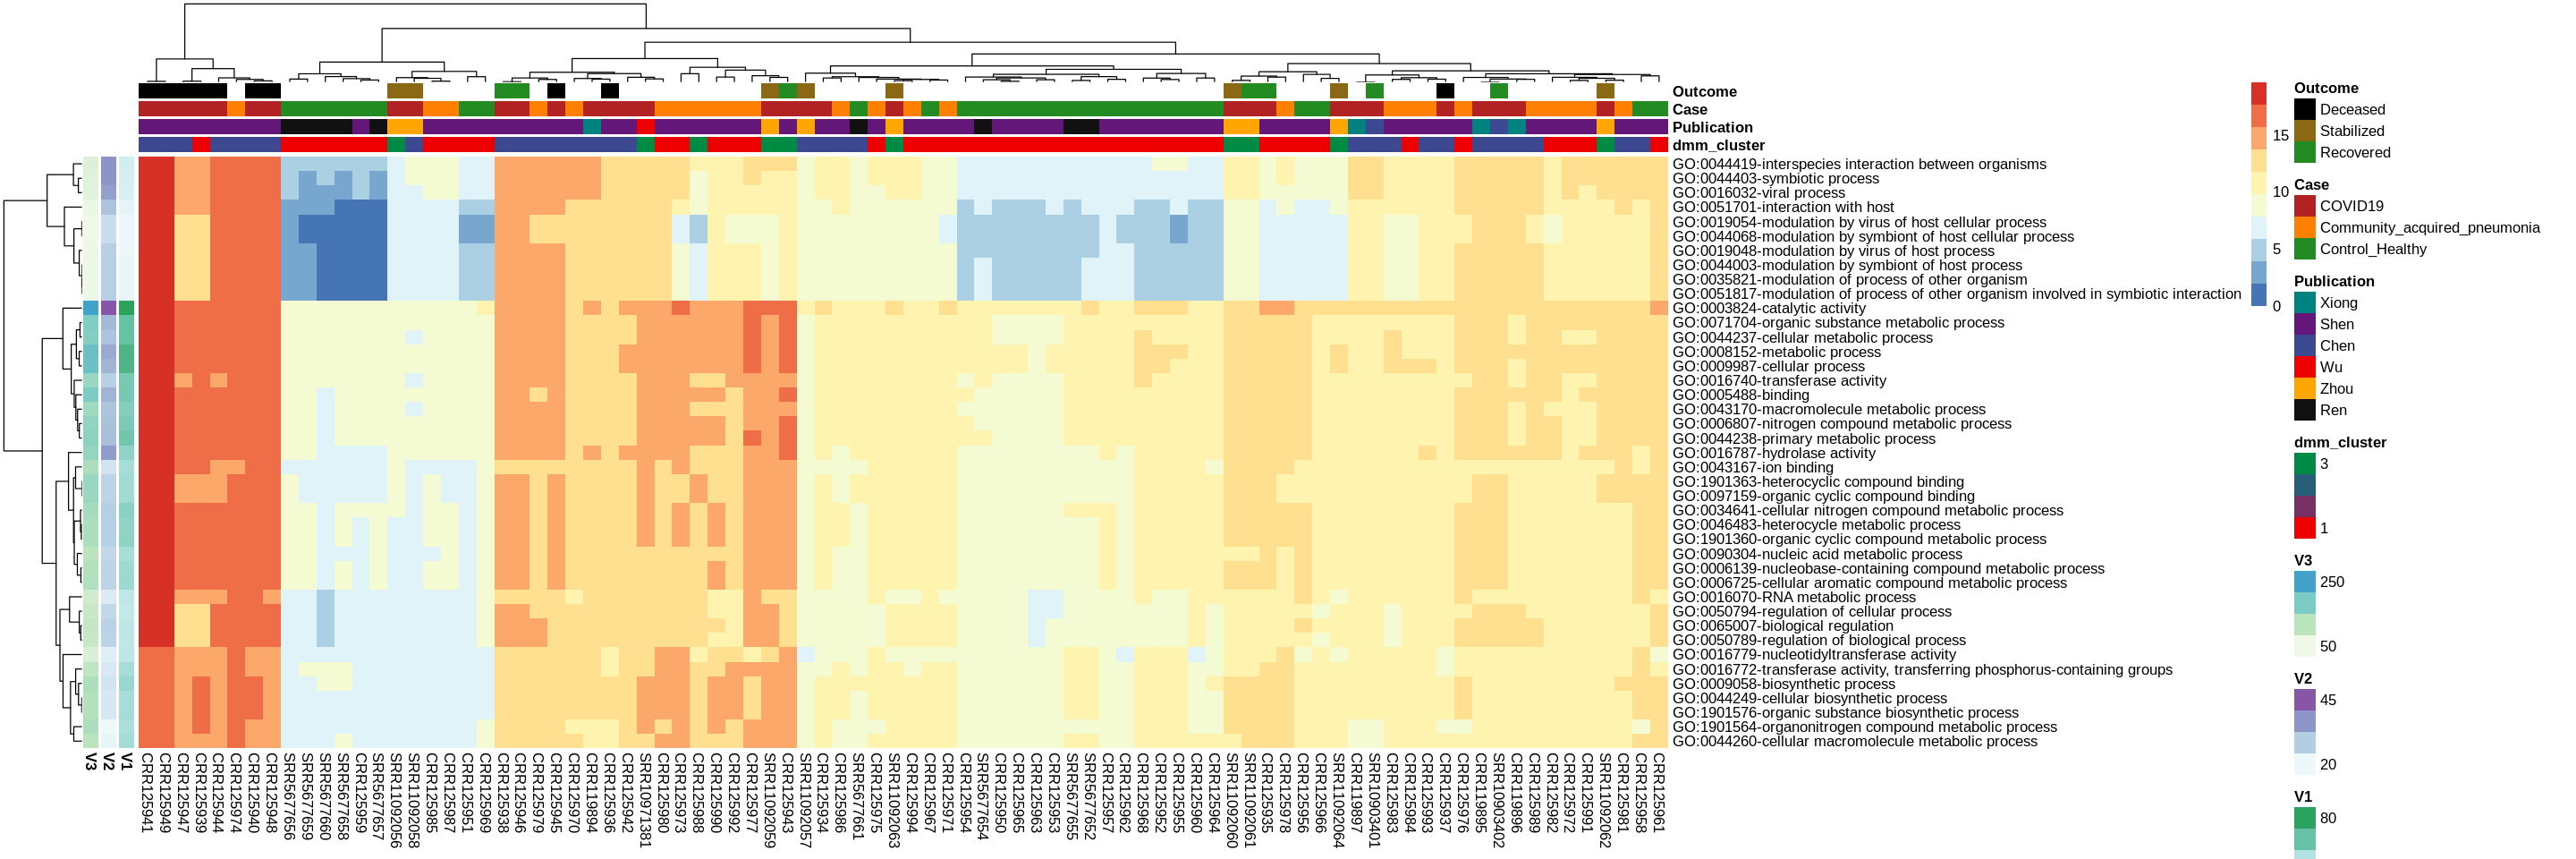

In [260]:
options(repr.plot.width=24, repr.plot.height=8)
xx <- pheatmap(mat = select2,
               color = colorRampPalette(rev(brewer.pal(n = 7, name ="RdYlBu")))(10),
               annotation_col=df,
               annotation_colors = ann_colors,
               clustering_distance_rows = "euclidean",
               clustering_distance_cols = "euclidean",
               annotation_row = df_row,
               cluster_row = T,
               cluster_col=T)

## OK GREAT JOB
### Ammendment that removes the publication coloumn

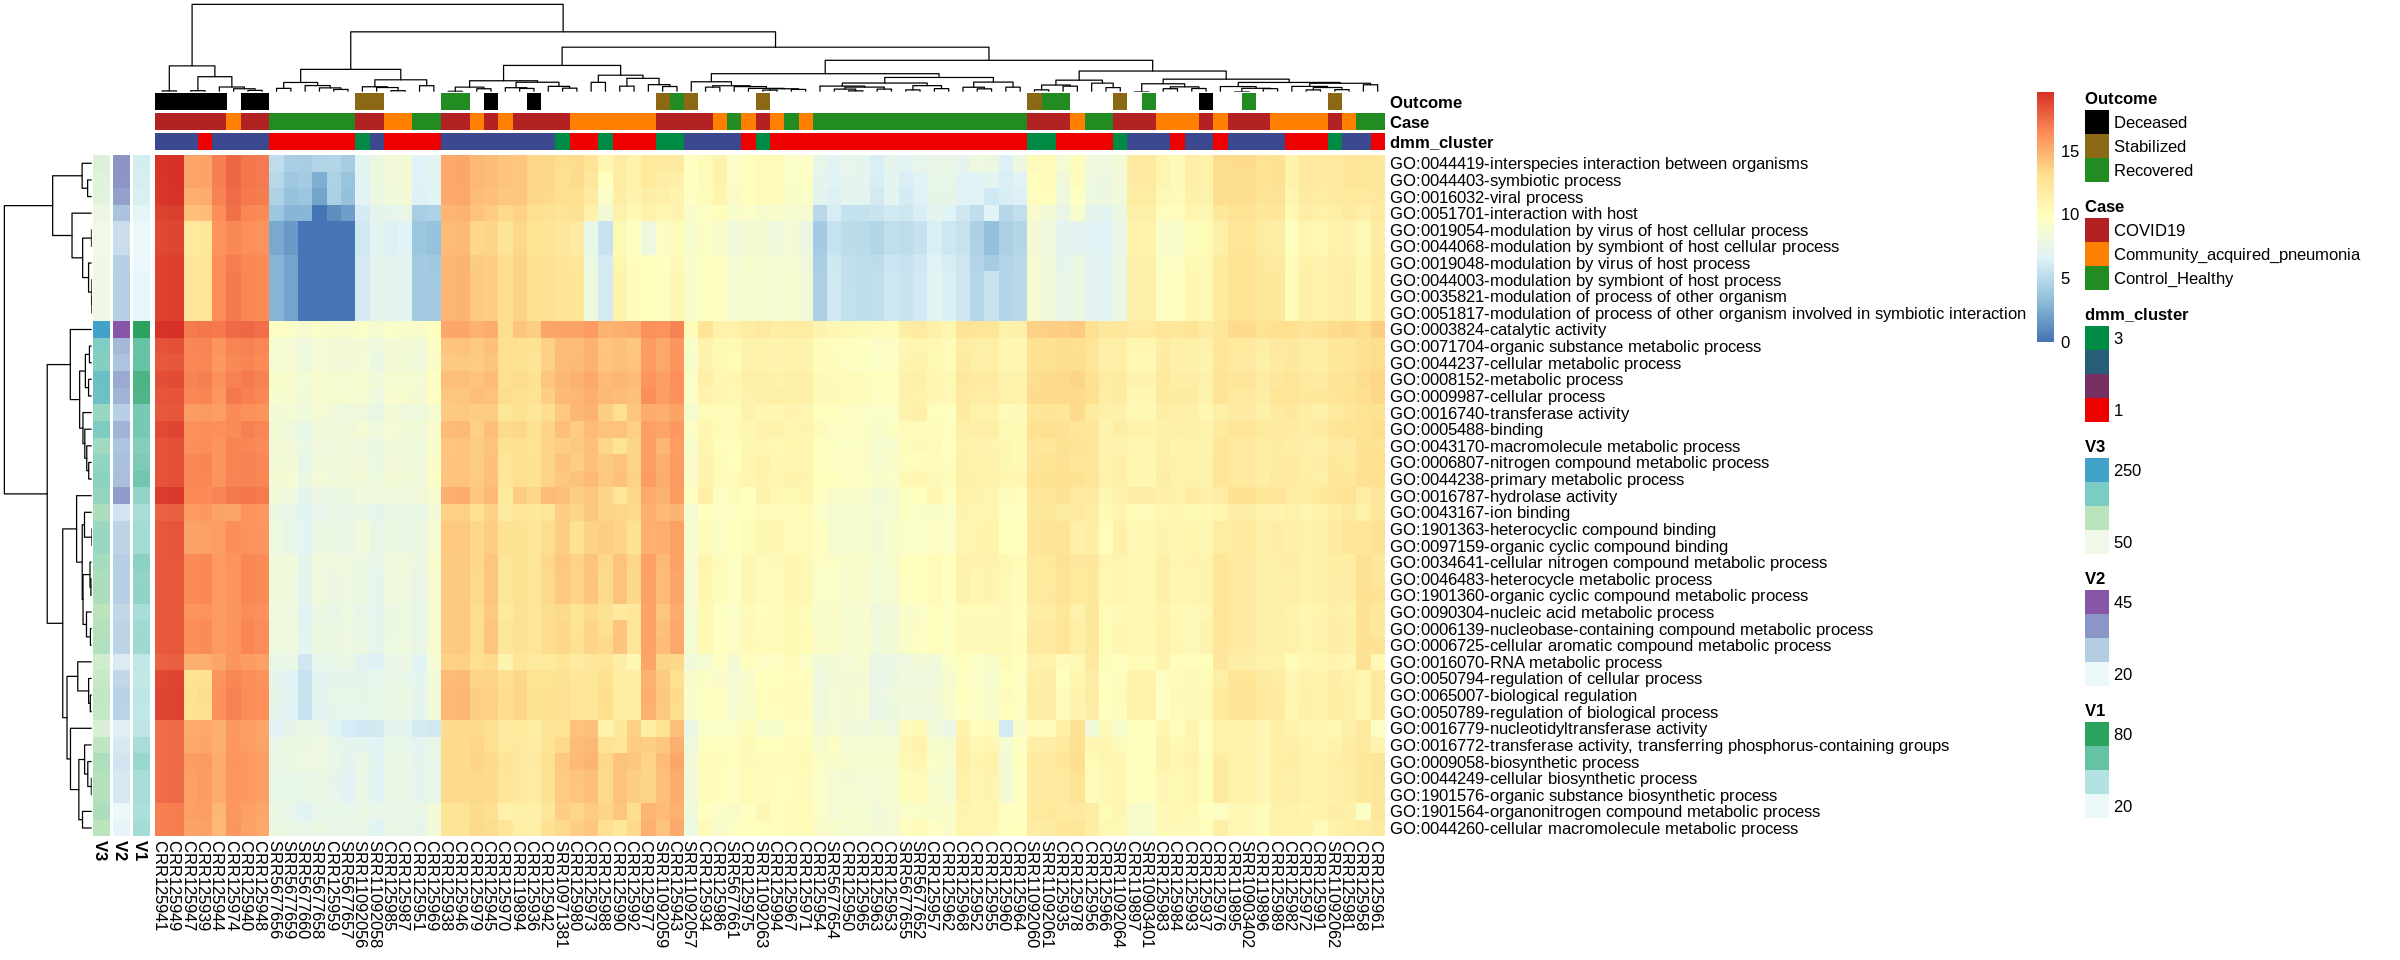

In [261]:
# Ammendment that removes the publication coloumn
df<-df%>%select(-Publication)
ann_colors = list(
  dmm_cluster=c("1"="#EE0000FF","2"="#3B4992FF","3"="#008B45FF"),#,"4"="#631879FF"),#,"5"="#008280FF","6"="#BB0021FF","7"="#5F559BFF"),
  Publication=c("Xiong"="#008280FF", "Shen"="#631879FF","Chen"="#3B4992FF","Wu"="#EE0000FF","Zhou"="orange","Ren"="#111111"),
  Case=c("COVID19"="firebrick","Community_acquired_pneumonia"="darkorange1", "Control_Healthy"="forestgreen"),
 # Sample_Type=c("COVID_19"="firebrick","Community_acquired_pneumonia"="darkorange1", "Healthy"="forestgreen"),
Outcome=c("Deceased"="black","Stabilized"="goldenrod4","Recovered"="forestgreen"))
options(repr.plot.width=20, repr.plot.height=8)
xx <- pheatmap(mat = select3,
               color = colorRampPalette(rev(brewer.pal(n = 7, name ="RdYlBu")))(1000),
               annotation_col=df,
               annotation_colors = ann_colors,
               clustering_distance_rows = "euclidean",
               clustering_distance_cols = "euclidean",
              annotation_row = df_row)



In [90]:
#BiocManager::install(c('FactoMineR','factoextra'))

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



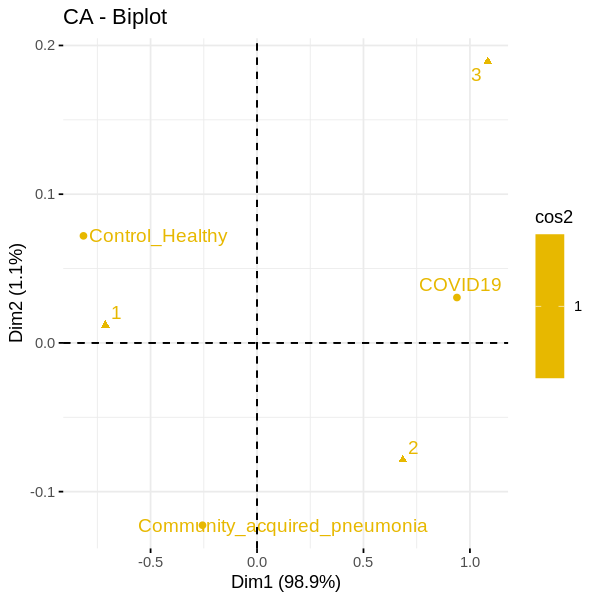

In [266]:
library('FactoMineR')
library('factoextra')
options(repr.plot.width=5, repr.plot.height=5)
a<-tally(~case+dmn,meta(term_pseq_prune))
res.CA<-CA(a,graph=F)
#res.CA
fviz_ca_biplot(res.CA,
               repel=T,
               col.col="cos2",
               col.row="cos2",
               gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"))

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



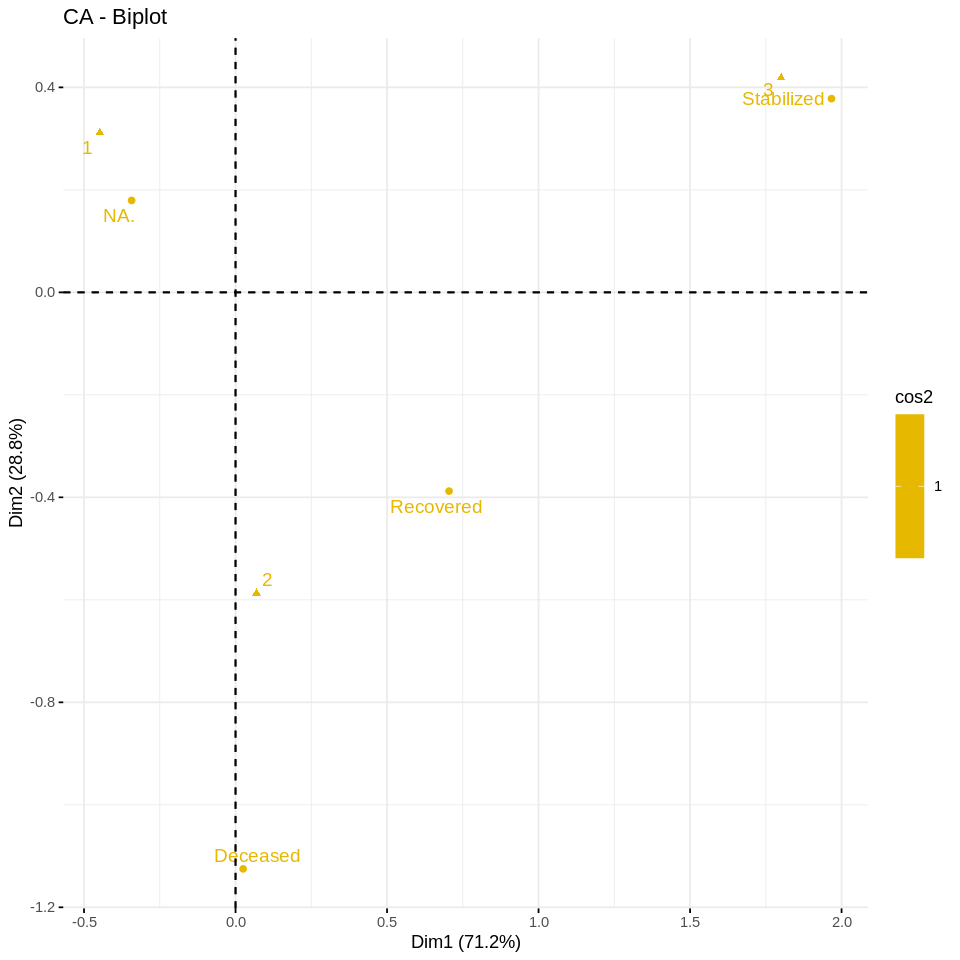

In [267]:
library('FactoMineR')
library('factoextra')
options(repr.plot.width=8, repr.plot.height=8)
a<-tally(~outcome+dmn,meta(term_pseq_prune))
res.CA<-CA(a,graph=F)
#res.CA
fviz_ca_biplot(res.CA,
               repel=T,
               col.col="cos2",
               col.row="cos2",
               gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"))